# Exploratory Data Analysis & Data Storytelling

**Table of Contents**

[Questions](#Questions)

[Loading Modules and Data](#Loading-Modules-and-Data)
* [Read Files](#Reading-Files)
* [Prepare Functions for Plotting](#Prepare-Functions-for-Plotting)

[Exploratory Data Analysis](#Exploratory-Data-Analysis)
* [Overview of Variables](#Overview-of-Variables)
* [totalPrice, squareMeters,pricePerSqMeter](#totalPrice,-squareMeters,-pricePerSqMeter)
* [EDA of Other Variables](#EDA-of-Other-Variables)
    * [District](#District)
    * [buildingType](#buildingType)
    * [buildingStructure](#buildingStructure)
    * [renovationCondition](#renovationCondition)
    * [constructionTime](#constructionTime)
    * [floorPosition, buildingFloors](#floorPosition,-buildingFloors)
    * [bedRoom, livingRoom, kitchen, bathRoom](#bedRoom,-livingRoom,-kitchen,-bathRoom)
    * [elevator, fiveYearsProperty, subway](#elevator,-fiveYearsProperty,-subway)

[Conclusions](#Conclusions)  


<a id=’Questions’></a>
## Questions

1. What is the trend of Beijing house pricing over time?
2. How does the location of the houses impact on the pricing?
3. How does the other features (building type, building structure, renovation condition, construction Time, number of rooms, access to subway, etc.) impact on the pricing?
4. What are the characteristics of each building type?

<a id=’Loading-Modules-and-Data’></a>
## Loading Modules and Data

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cycler
import seaborn as sns
from descartes import PolygonPatch
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
plt.style.use('seaborn-ticks')

<a id=’Read-Files’></a>
### Reading Files

In [2]:
#Load Data
df = pd.read_csv('Data/BeijingHousePricing_Cleaned.csv', parse_dates=['tradeTime'],index_col= 'id', 
                 dtype={'buildingType' : 'category', 'renovationCondition' : 'category',
                        'buildingStructure' : 'category', 'elevator' : 'category',
                        'fiveYearsProperty' : 'category', 'subway' : 'category',
                        'district' : 'category', 'floorPosition' : 'category'})
pd.set_option('display.float_format', lambda x: '%.3f' % x)
df.sort_values('tradeTime', ascending = True, inplace=True)

/Users/NancyMao/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
#Load beijing shapefile data
sf = gpd.read_file('Data/beijing.shp')
sf.NAME_2 = sf.NAME_2.apply(
    lambda x: 'TongZhou' if x == '通州区'
    else ('Shunyi' if x == '顺义区'
          else ('ChangPing' if x == '昌平区'
                else ('DaXing' if x == '大兴区'
                      else ('HuaiRou' if x == '怀柔区'
                           else ('PingGu' if x == '平谷区'
                                else ('MiYun' if x == '密云区'
                                     else ('YanQing' if x == '延庆区'
                                          else ('DongCheng' if x == '东城区'
                                               else ('XiCheng' if x == '西城区'
                                                    else ('ChaoYang' if x == '朝阳区'
                                                         else ('FengTai' if x =='丰台区'
                                                              else ('ShiJingShan' if x == '石景山区'
                                                                   else ('HaiDian' if x == '海淀区'
                                                                       else ('MenTouGou' if x == '门头沟区'
                                                                           else ('FangShan' if x == '房山区'
                                                                                 else x))))))))))))))))

In [4]:
#Data wrangling on shapefile data
sf_district = sf[['NAME_2', 'geometry']].dissolve(by='NAME_2')
sf_district.reset_index(inplace=True)
sf_district['coords'] = sf_district['geometry'].apply(lambda x: x.representative_point().coords[:])
sf_district['coords'] = [coords[0] for coords in sf_district['coords']]
sf_district.at[3,'coords']=(116.43, 39.88)
sf_district.at[8,'coords']=(116.05, 39.97)
sf_district.at[4,'coords']=(116.1, 39.7)

In [5]:
df.pricePerSqMeter.describe()

count   316222.000
mean     43567.725
std      21643.657
min         44.000
25%      28096.000
50%      38776.000
75%      53847.000
max     156250.000
Name: pricePerSqMeter, dtype: float64

<a id=’Prepare-Functions-for-Plotting’></a>
### Prepare Functions for Plotting

In [6]:
def get_sub_plots(n_total_cols, n_cols, fig_lng, fig_hgt, sharey=False, label_font_size = 12, tick_font_size = 11):
    n_rows = int(n_total_cols / n_cols)
    if n_total_cols % n_cols != 0:
        n_rows += 1

    fig, axes = plt.subplots(nrows = n_rows, ncols = n_cols,sharey = sharey)
    
    fig.set_size_inches(fig_lng, fig_hgt)  
    
    if n_total_cols % n_cols != 0:
        for col in range(n_total_cols % n_cols, n_cols):
            fig.delaxes(axes[n_rows - 1][col])
            
    axes = axes.flatten()
    
    for ax in axes:
        ax.xaxis.set_major_locator(plt.AutoLocator())
        ax.tick_params(labelsize = tick_font_size)
        ax.set_xlabel(ax.get_xlabel(), fontsize = label_font_size)
        ax.set_ylabel(ax.get_ylabel(), fontsize = label_font_size)

    return (fig, axes)


def plot_hist_and_cumulative_hist(data, n_cols = 2):
    n_total_cols = 2
    fig, axes = get_sub_plots(n_total_cols, n_cols, fig_lng = 15, fig_hgt =5)
    
    sns.distplot(a = data, ax = axes[0])
    sns.distplot(a = data, hist_kws={'cumulative': True}, kde_kws={'cumulative':True},  ax = axes[1])
    
    axes[0].set_title(label = 'Histogram', fontsize = 14)
    axes[1].set_title(label = 'Cumulative Histogram', fontsize = 14)
    
    fig.tight_layout()    
    plt.show()
    

def box_and_count_plot(x, y, data):
    fig, axes = get_sub_plots(n_total_cols = 2, n_cols =2, fig_lng = 20, fig_hgt =5)

    sns.boxplot(x = x, y = y, data = data, ax=axes[0], color = 'steelblue')
    sns.countplot(x = x, data = df, ax=axes[1], color = 'steelblue', linewidth=1,
                   edgecolor='darkslategray')

    i=0
    for p in axes[1].patches:
        height = p.get_height()
        axes[1].text(p.get_x()+p.get_width()/2, height*1.007, df[x].value_counts()[i],ha="center", fontsize = 11)
        i += 1

    fig.tight_layout()
    plt.show()    

    
def room_box_pot(data,x):

    fig, axes = get_sub_plots(n_total_cols=3, n_cols=3, fig_lng = 20, fig_hgt = 5)
    g1 = sns.boxplot(x = x, y = 'pricePerSqMeter',data = df, ax = axes[0], color = 'steelblue')
    g2 = sns.boxplot(x = x, y = 'totalPrice',data = df, ax = axes[1], color = 'steelblue')
    g3 = sns.boxplot(x = x, y = 'squareMeters',data = df, ax = axes[2], color = 'steelblue')
    plt.show()
    

def plot_map(ax, x ='Lng', y ='Lat'):
    plt.style.use('seaborn-notebook')
    sf_district.boundary.plot(linewidth = 0.5, ax = ax, color = '#ABB2B9')
    for idx, row in sf_district.iterrows():
        ax.annotate(s=row['NAME_2'], xy=row['coords'],horizontalalignment='center', fontsize = 9)

    ax.set_xlim([115.966,116.791])
    ax.set_ylim([39.527,40.352])
    
    return ax  


def numerical_scatter_plot_on_map(data, c, ax, x = df['Lng'], y = df['Lat'], title=None):
    #plot 99% of the observations on map to avoid outliers skewing the colorbar
    v_min=data[c].quantile(0.005)
    v_max=data[c].quantile(0.995)
    
    plot_map(ax=ax)
    points = ax.scatter(x = x, y = y, c = data[c], cmap = 'YlGnBu', s = 1, vmin = v_min, vmax = v_max)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(points, ax=ax, cax=cax)
    cbar.ax.set_title(label = c, fontsize=9)
    cbar.ax.tick_params(labelsize=9)
    
    if title is not None:
        ax.set_title(label = title, fontsize = 12)
    

def numerical_on_map_by_category(data, cat, fighgt, figlng=15, ncols=3, c='pricePerSqMeter'):
    labels = list(data[cat].sort_values().unique())
    n = len(labels)

    fig, axes = get_sub_plots(n_total_cols = n, n_cols=ncols, fig_lng=figlng, fig_hgt=fighgt)

    for ax, label in zip(axes.flatten(), labels):
        sub_df = data.loc[data[cat] == label]
        numerical_scatter_plot_on_map(data=sub_df, c=c,
                                      ax = ax, x = sub_df['Lng'], y = sub_df['Lat'], title = label)

    plt.tight_layout()
    plt.show()    


<a id=’Exploratory-Data-Analysis’></a>
## Exploratory Data Analysis

<a id=’Overview-of-Variables’></a>
### Overview of Variables

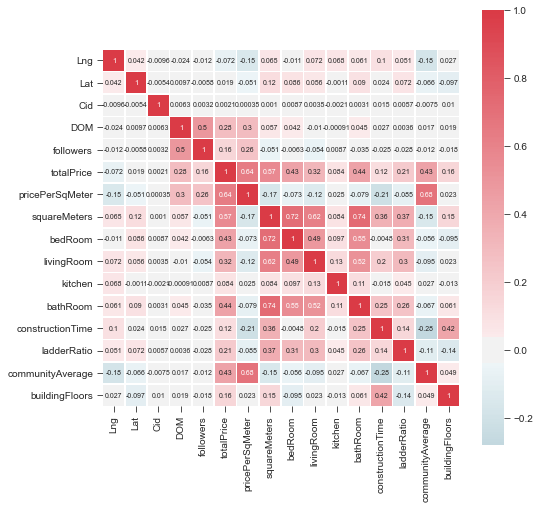

In [7]:
#Correlation Heatmap
corr = df.corr()
cmap = sns.diverging_palette(220, 10, as_cmap=True)

fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(corr, cmap=cmap, center=0, square=True, linewidths=.5, annot=True, annot_kws={"size": 7}, ax=ax)

plt.show()

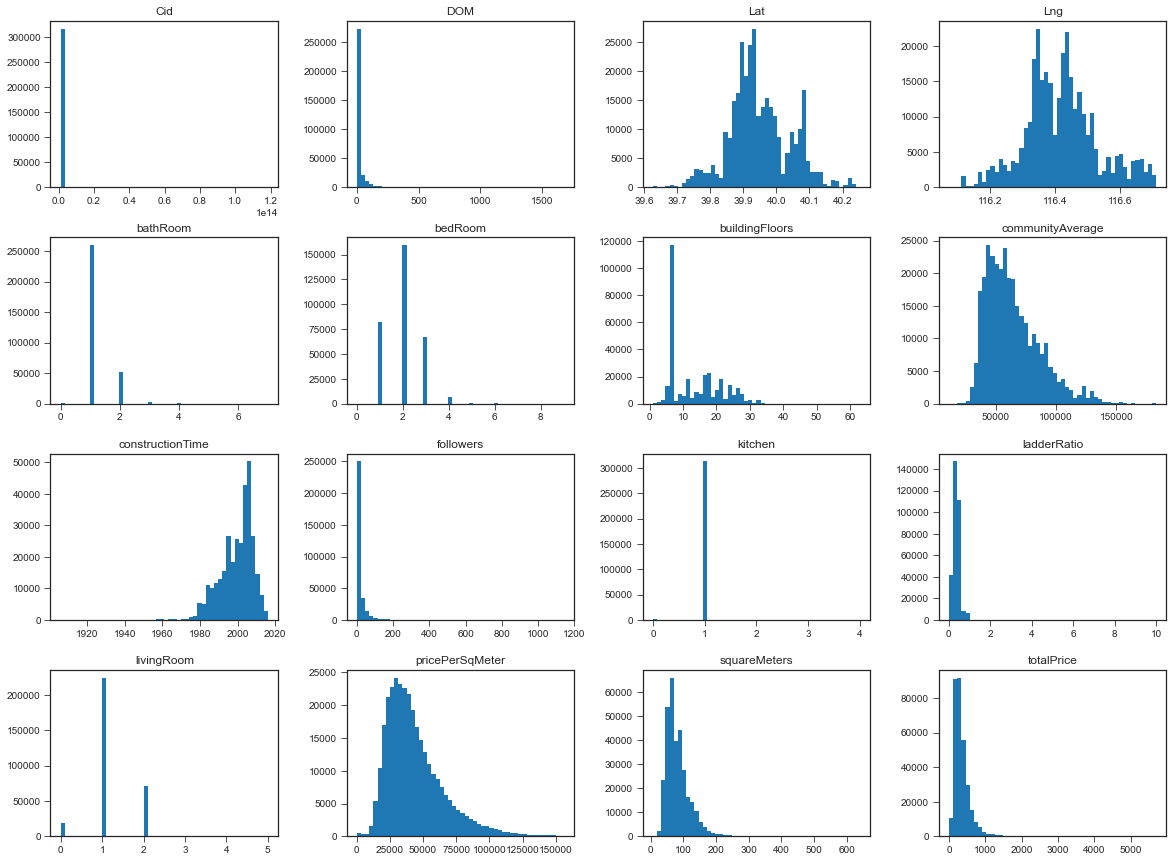

In [8]:
#Numeraical Variable Histograms
df.hist(bins=50, figsize=(20,15), grid=False)
plt.show()

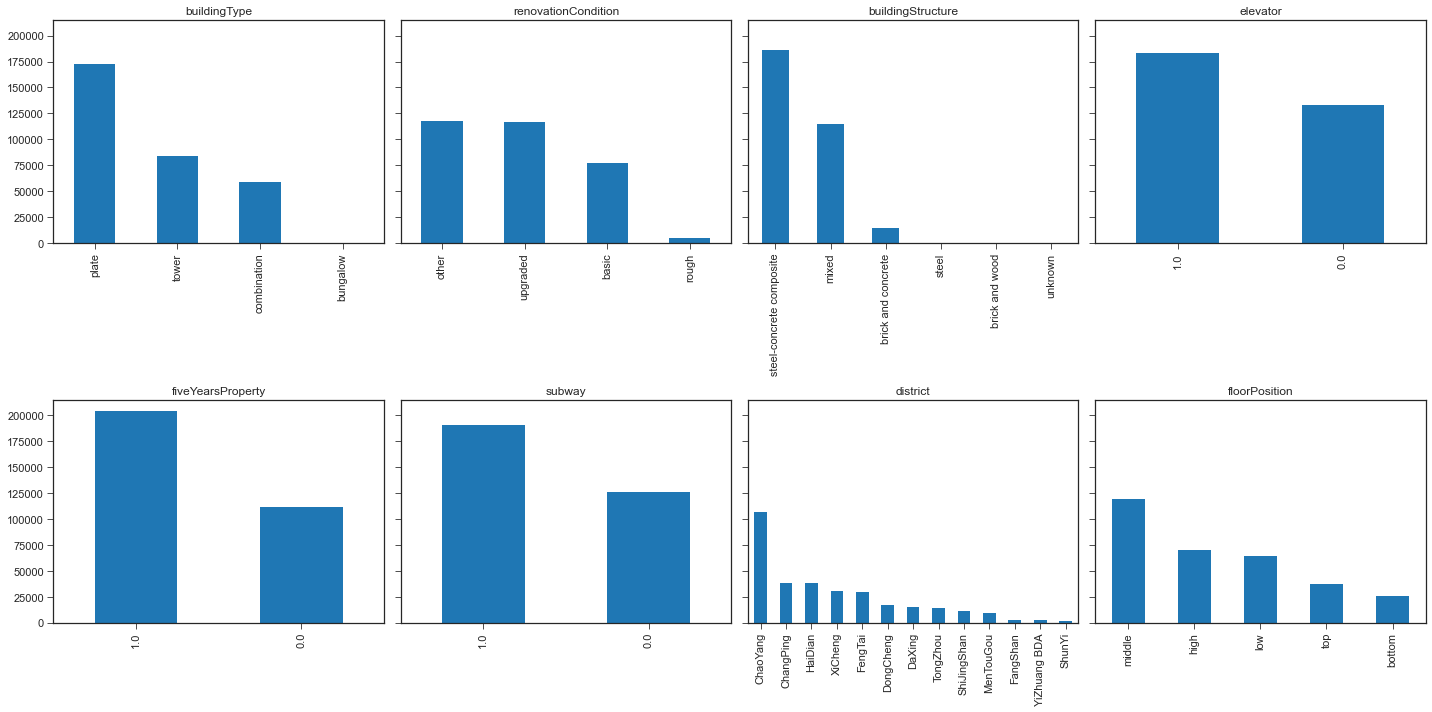

In [9]:
#Categorical Variable Countplots
categorical_columns = list(df.select_dtypes(include='category'))
n=len(categorical_columns)

fig, axes = get_sub_plots(n_total_cols = n, n_cols =4, fig_lng = 20, fig_hgt =10, sharey = True) 

axes = axes.flatten()

for ind, col in enumerate(categorical_columns): 
    data = df[col].value_counts()
    data.plot(kind='bar', title = col, ax = axes[ind])

plt.tight_layout()   
plt.show()

<a id=’totalPrice,-squareMeters,-pricePerSqMeter’></a>
### totalPrice, squareMeters, pricePerSqMeter

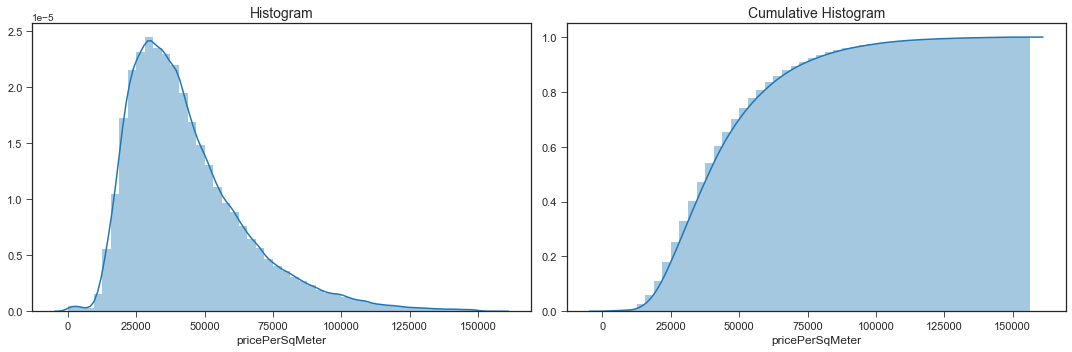

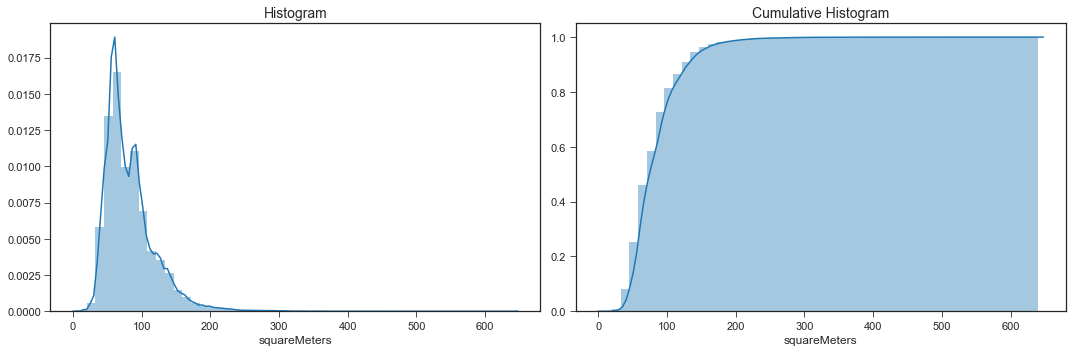

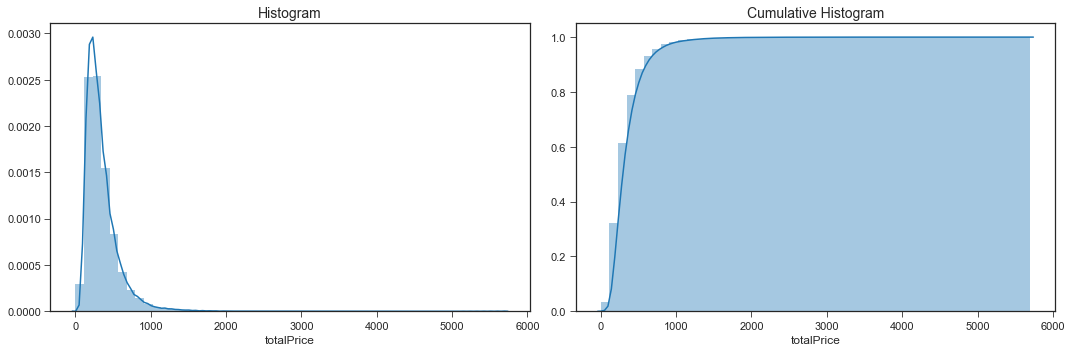

In [10]:
plot_hist_and_cumulative_hist(data = df['pricePerSqMeter'])
plot_hist_and_cumulative_hist(data = df['squareMeters'])
plot_hist_and_cumulative_hist(data = df['totalPrice'])

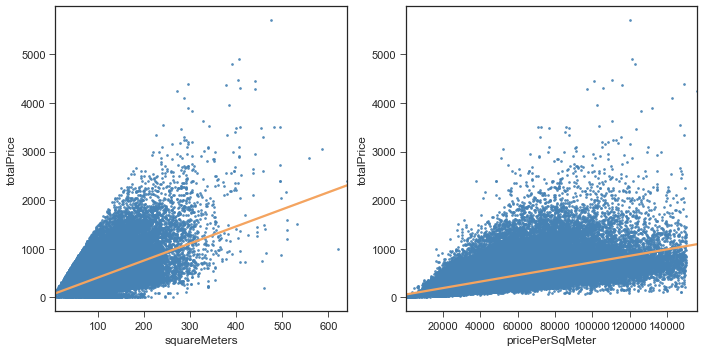

In [11]:
#Visualize Linear Regression of these variables
fig, axes = get_sub_plots(n_total_cols = 2, n_cols =2, fig_lng = 10, fig_hgt =5)
sns.regplot(data=df, x='squareMeters',y='totalPrice', ax=axes[0],
           line_kws={'color': 'sandybrown'}, scatter_kws={'s':3, 'color': "steelblue"})
sns.regplot(data=df, x='pricePerSqMeter',y='totalPrice', ax=axes[1],
                     line_kws={'color': 'sandybrown'}, scatter_kws={'s':3, 'color': "steelblue"})
plt.tight_layout()
plt.show()

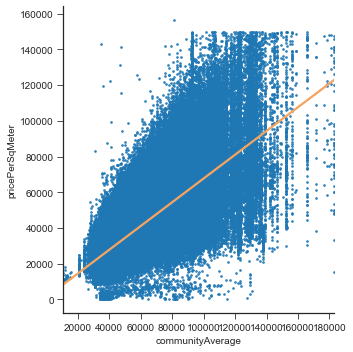

In [12]:
#Linear Regression on conmunity average price and pricePerSqMeter of each house
sns.lmplot(data=df, x='communityAverage',y='pricePerSqMeter', 
           line_kws={'color': 'sandybrown'}, scatter_kws={'s':3}, height=5)
plt.show()

Community Average price has a positive correlation of the price of individual houses which is expected

<a id=’EDA-of-Other-Variables’></a>
### EDA of Other Variables

<a id=’District’></a>
#### District

In [13]:
#Prepare data of pricePerSqMeter median by month-year
price_midian = df.groupby(df['tradeTime'].dt.strftime('%Y-%m'))['pricePerSqMeter'].median()
price_midian_district = df.groupby([df['tradeTime'].dt.strftime('%Y-%m'),'district'])['pricePerSqMeter'].median()
price_midian_district = price_midian_district.unstack(level=-1)

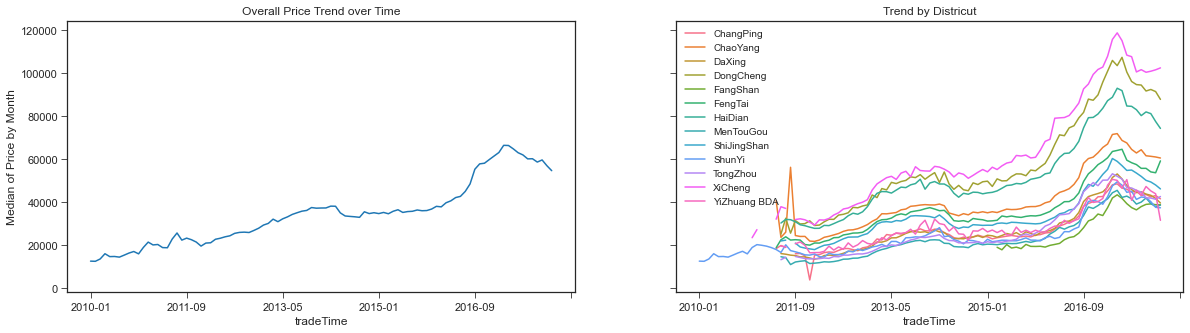

In [14]:
#plot median price over time
NUM_COLORS = len(price_midian_district.columns)
cm = ListedColormap(sns.color_palette("husl", 13))

fig, axes = get_sub_plots(n_total_cols = 2, n_cols =2, fig_lng = 20, fig_hgt =5, sharey = True) 
axes[1].set_prop_cycle('color',[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])

price_midian_district.plot(ax=axes[1])
axes[1].set_title('Trend by Districut')
price_midian.plot(ax=axes[0])
axes[0].set_title('Overall Price Trend over Time')
axes[0].set_ylabel('Median of Price by Month')

plt.legend()
plt.show()

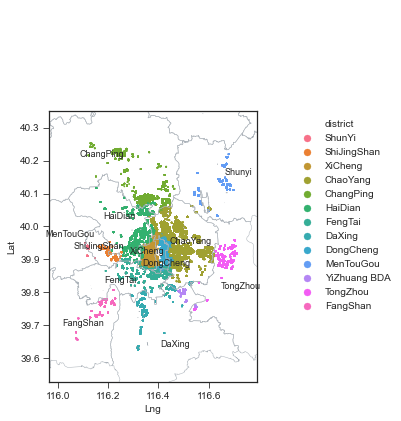

In [15]:
#plot houses by district on map
plt.style.use('seaborn-ticks')
fig, ax = plt.subplots(figsize=(5, 5))
plot_map(ax=ax)
sns.scatterplot(data=df,x='Lng', y ='Lat', hue='district', ax = ax, edgecolor=None, s=1)

leg = ax.get_legend()
leg.set_bbox_to_anchor((1.15,1))

plt.show()

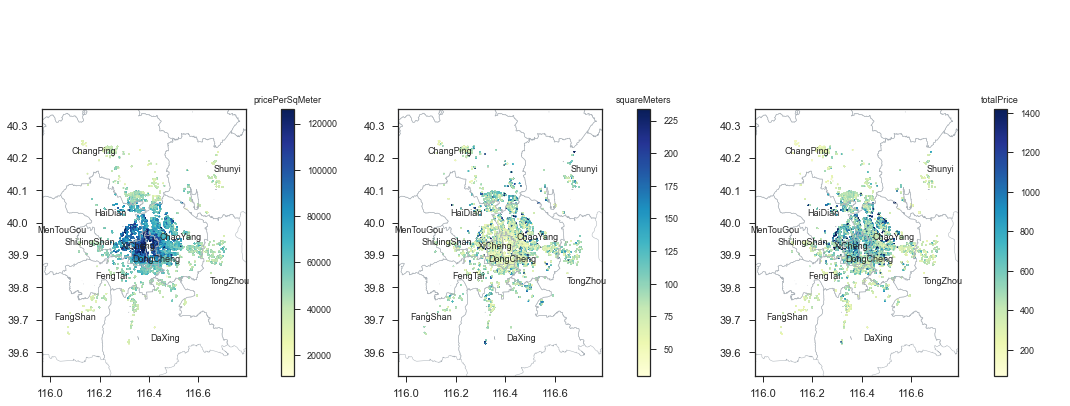

In [16]:
#plot pricePerSqmeter, SquareMeters, totalPrice on Map
plt.style.use('seaborn-ticks')
fig, axes = get_sub_plots(n_total_cols = 3, n_cols =3, fig_lng = 15, fig_hgt =5)
numerical_scatter_plot_on_map(data = df, c ='pricePerSqMeter', ax = axes[0])
numerical_scatter_plot_on_map(data = df, c ='squareMeters', ax = axes[1])
numerical_scatter_plot_on_map(data = df, c ='totalPrice', ax = axes[2])

plt.tight_layout()
plt.show()

We can see that houses in the urban area or around the center of the city have higher price per Sq. Meter. Xicheng, Dongcheng and Haidian districts have the most expensive house price medians

<a id=’buildingType’></a>
#### buildingType

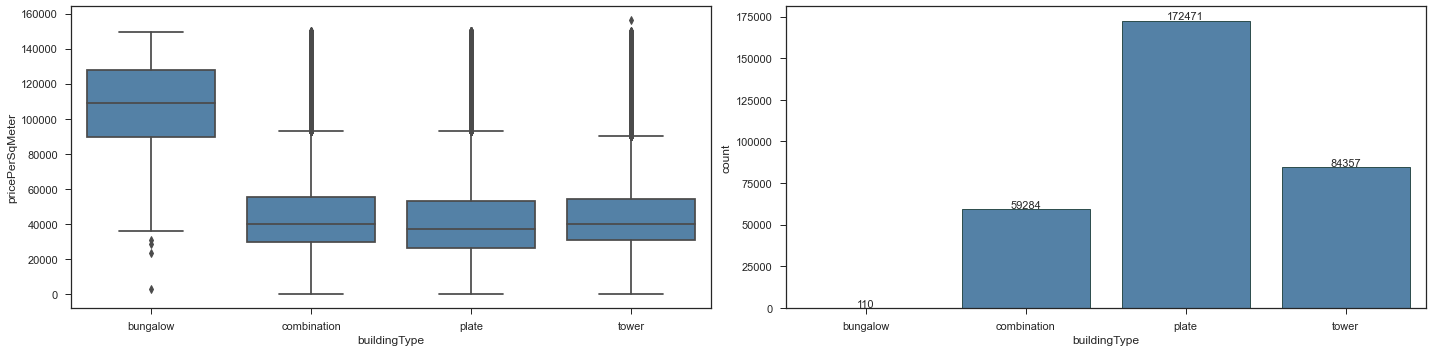

In [17]:
box_and_count_plot(x='buildingType', y='pricePerSqMeter', data=df)

Houses with bungalow building type show significant higher price per Sq. Meter than other type.

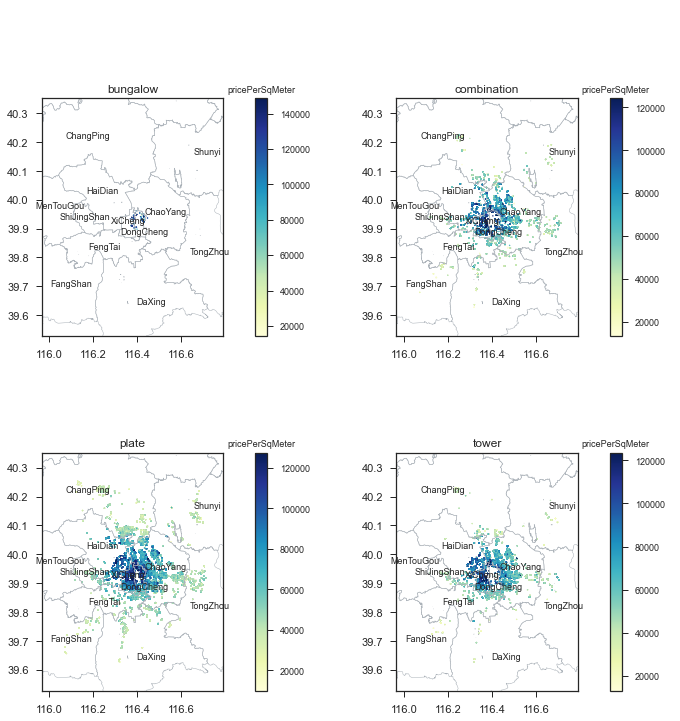

In [18]:
#plot pricePerSqMeter on map by buildingType
numerical_on_map_by_category(data=df, cat='buildingType', fighgt=10, ncols=2, figlng=10)

Bungalow houses are mainly in DongCheng and XiCheng districts where Tiananmem Square and Forbidden City locate

<a id=’buildingStructure’></a>
#### buildingStructure

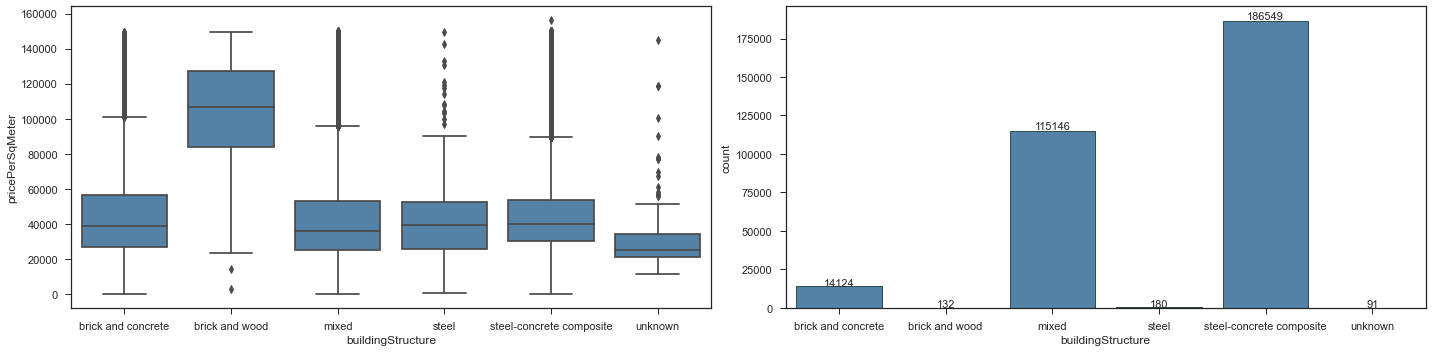

In [19]:
box_and_count_plot(x='buildingStructure', y='pricePerSqMeter', data=df)

Houses with 'brick and wood' structure have higher price than the other types of structures

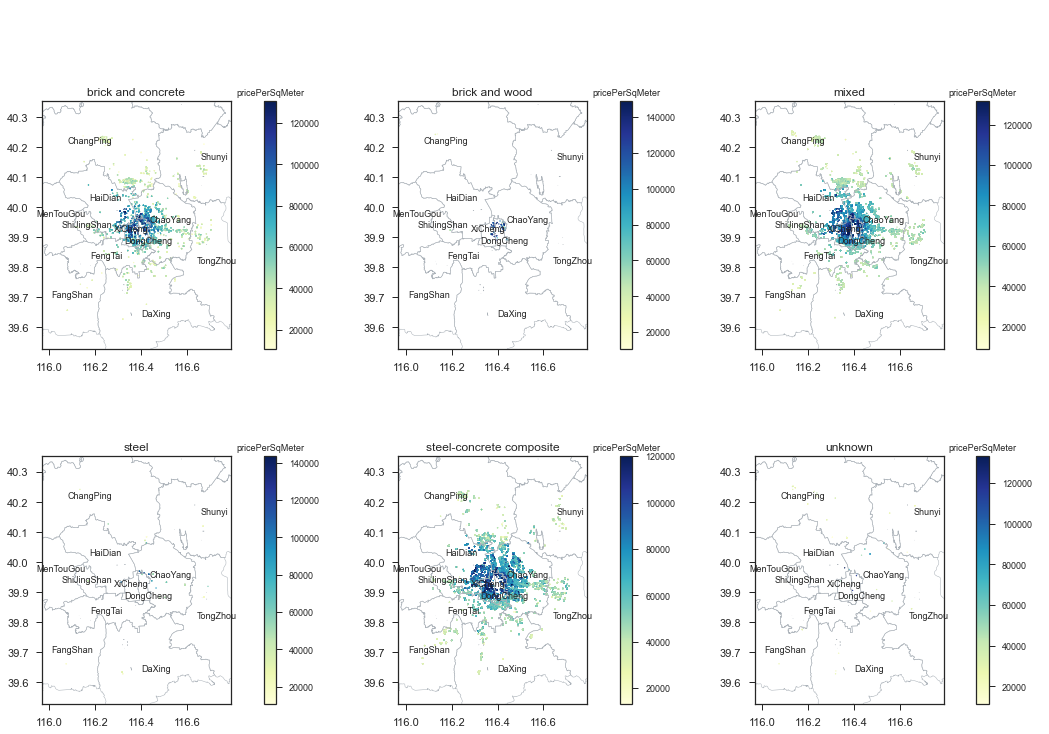

In [20]:
#plot pricePerSqMeter on map by buildingStructure
numerical_on_map_by_category(data=df, cat='buildingStructure', fighgt=10)

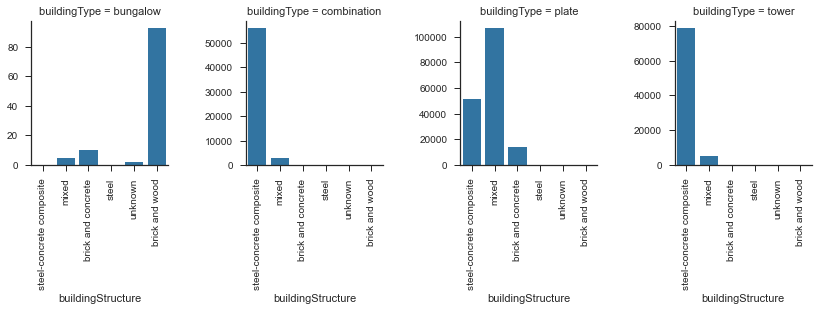

In [21]:
#Facidgrid of countplot on buildingStrucutre by buildingType
g = sns.FacetGrid(df, col='buildingType', sharey=False)
g = g.map(sns.countplot,'buildingStructure', order=df.buildingStructure.unique())
g.set_xticklabels(rotation=90)

plt.show()

Houses with 'brick and wood' structure overlap with houses with 'bungalow' building type on map. 

<a id=’renovationCondition’></a>
#### renovationCondition

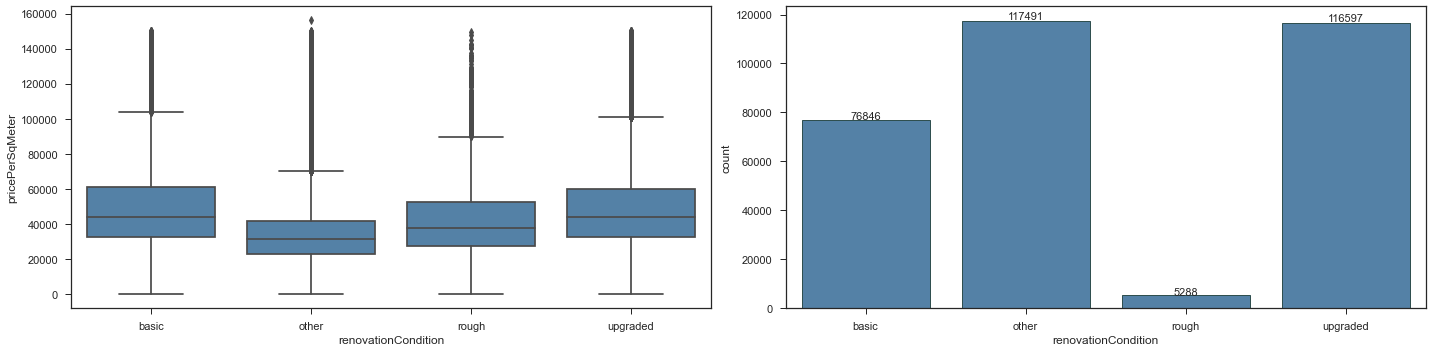

In [22]:
box_and_count_plot(x='renovationCondition', y='pricePerSqMeter', data=df)

The meaning "Other" renovation condition type is not clear to us. Houses with "rough" renovation conditions have a lower price than the "basic" and "upgraded" condition which is expected. There is not much difference in pricing for "basic" and "upgraded" renovation conditions.  

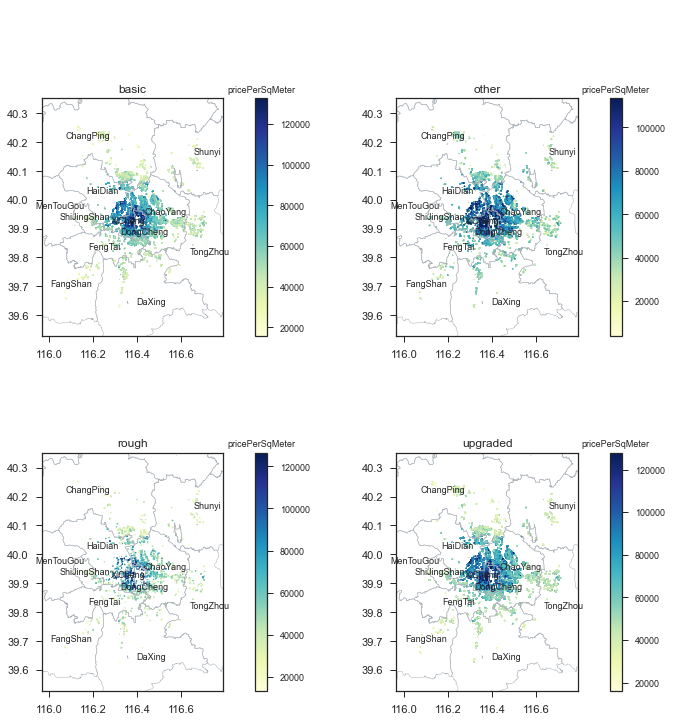

In [23]:
#plot pricePerSqMeter on map by renovation condition
numerical_on_map_by_category(data=df, cat='renovationCondition', fighgt=10, ncols=2, figlng=10)

<a id=’constructionTime’></a>
#### constructionTime

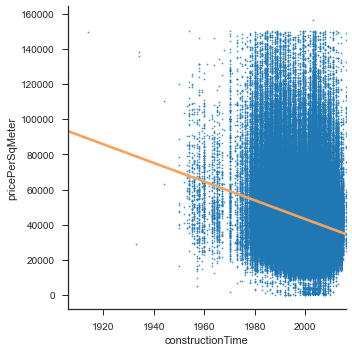

In [24]:
#Linear Regression of Price over construction time
sns.lmplot(data=df, x='constructionTime',y='pricePerSqMeter', 
           line_kws={'color': 'sandybrown'}, scatter_kws={'s':3}, height=5)
plt.show()

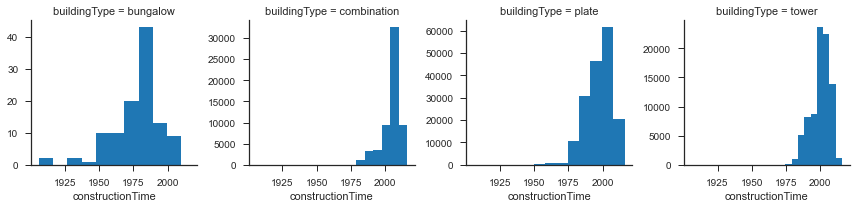

In [25]:
#Facidgrid of histogram on constructionTime by buildingType
g = sns.FacetGrid(df, col='buildingType', sharey=False)
g = g.map(plt.hist, 'constructionTime')

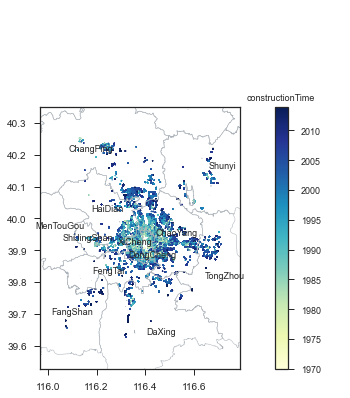

In [26]:
#Plot constructionTime of houses on map
fig, ax = plt.subplots(figsize=(5,5))
numerical_scatter_plot_on_map(data = df, c ='constructionTime', ax = ax)

We can see that house building have been expanding outward from the city center over time

<a id=’floorPosition,-buildingFloors’></a>
#### floorPosition, buildingFloors

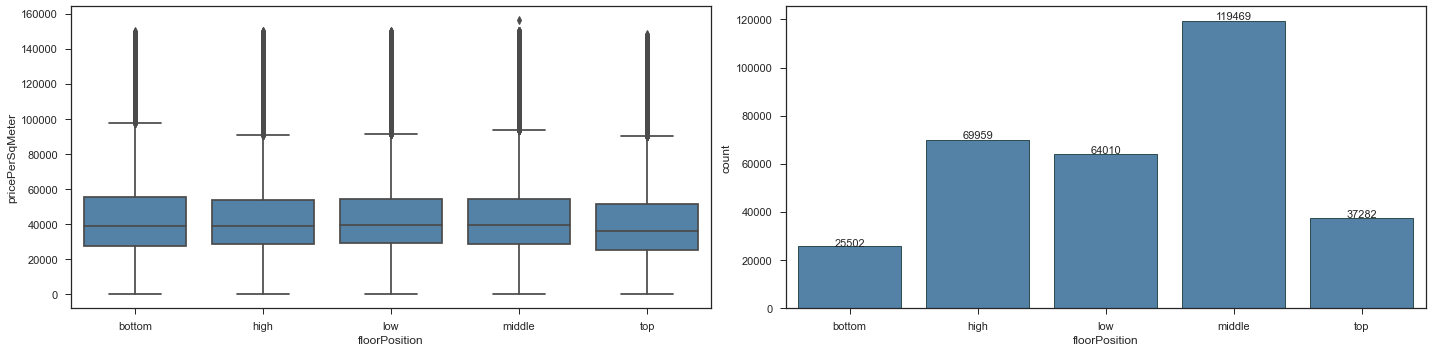

In [27]:
box_and_count_plot(x='floorPosition', y='pricePerSqMeter', data=df)

There is not much difference in pricing for houses at different floor positions

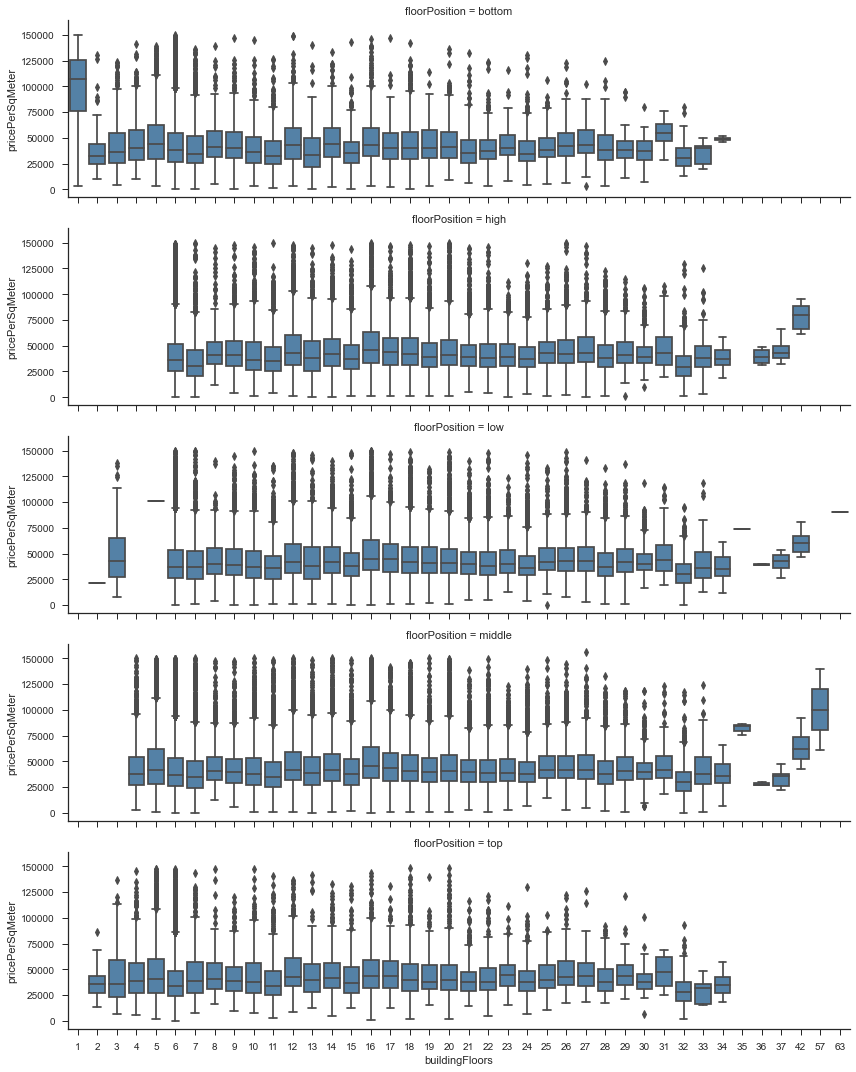

In [28]:
#Boxplot of price on buildingFloors by floorPosition
g = sns.catplot(x='buildingFloors', y='pricePerSqMeter',
                row='floorPosition',data=df, kind='box', height=3, aspect=4, color='steelblue')

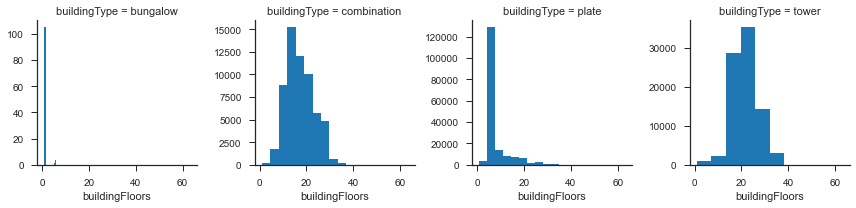

In [29]:
#Facidgrid of histogram on buildingFloors by buildingType
g = sns.FacetGrid(df, col='buildingType', sharey=False)
g = g.map(plt.hist, 'buildingFloors')

Tower buildings in general are the highest building type with more floors. Combination buildings are the second following. Bungalow type of buildings only have one floor.

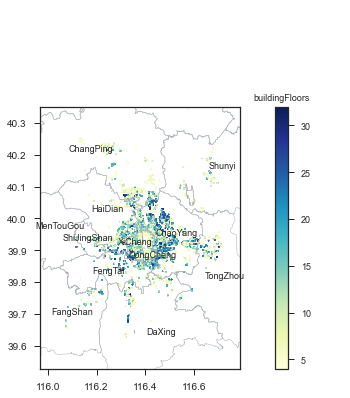

In [30]:
#Plot buildingFloors of houses on map
fig, ax = plt.subplots(figsize=(5,5))
numerical_scatter_plot_on_map(data = df, c ='buildingFloors', ax = ax)

<a id=’bedRoom,-livingRoom,-kitchen,-bathRoom’></a>
#### bedRoom, livingRoom, kitchen, bathRoom

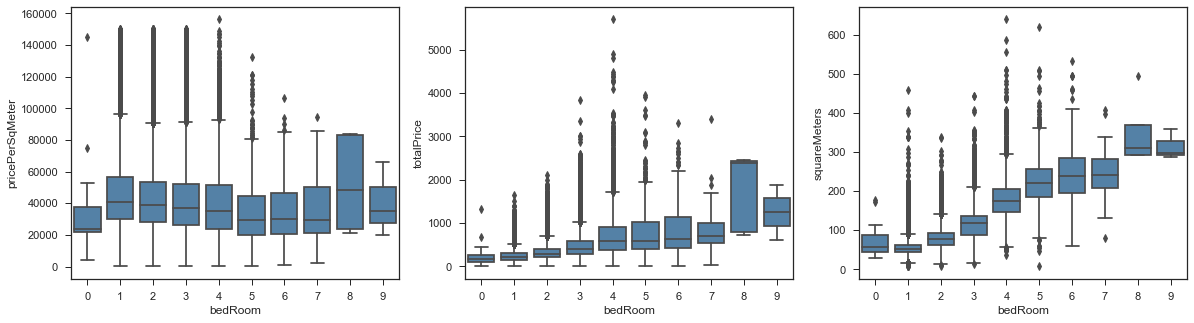

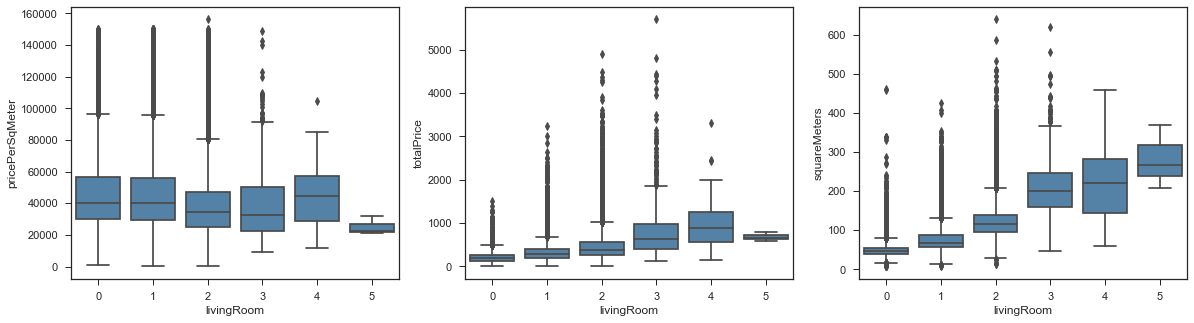

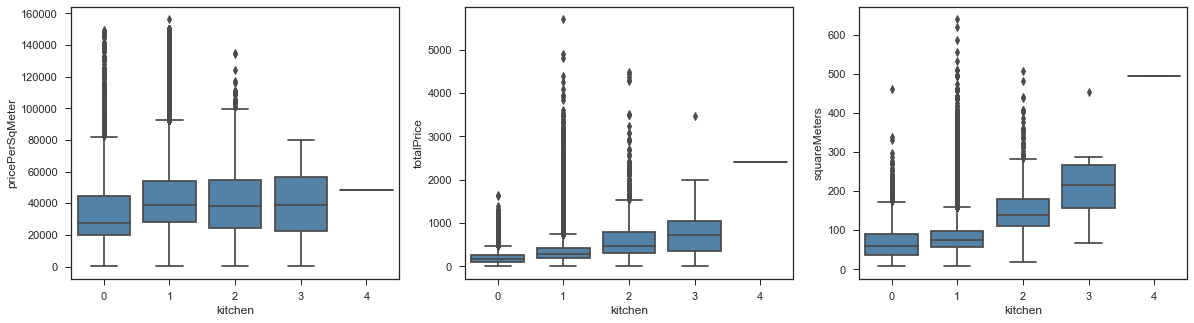

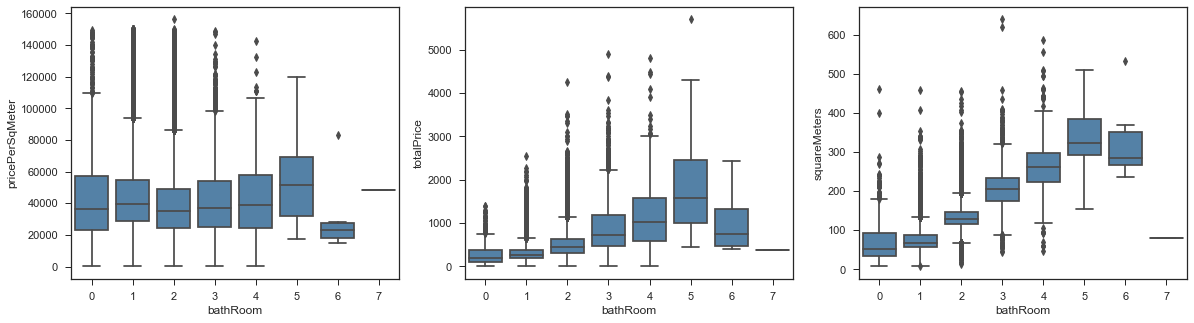

In [31]:
#box plot on pricePerSqMeter, totalPrice and squreMeter
room_box_pot(data=df,x='bedRoom')
room_box_pot(data=df,x='livingRoom')
room_box_pot(data=df,x='kitchen')
room_box_pot(data=df,x='bathRoom')

<a id=’elevator,-fiveYearsProperty,-subway’></a>
#### elevator, fiveYearsProperty, subway

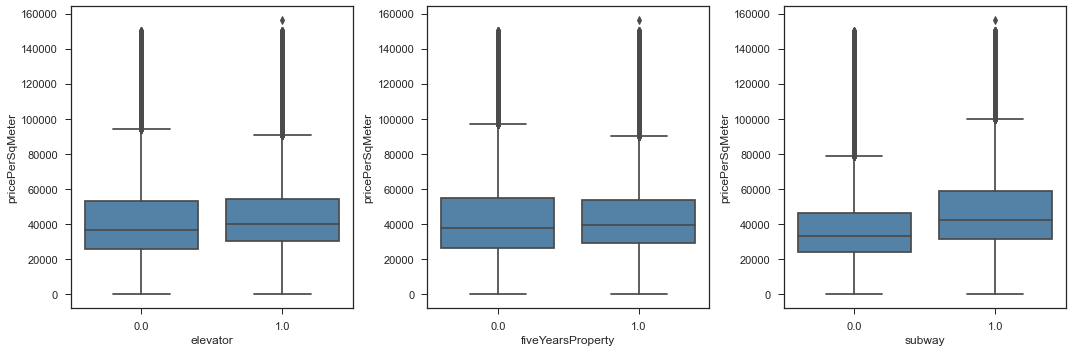

In [32]:
plt.style.use('seaborn-ticks')
fig, axes = get_sub_plots(n_total_cols = 3, n_cols =3, fig_lng = 15, fig_hgt =5)

sns.boxplot(x = 'elevator', y = 'pricePerSqMeter', data = df, ax=axes[0], color = 'steelblue')
sns.boxplot(x = 'fiveYearsProperty', y = 'pricePerSqMeter', data= df, ax=axes[1], color = 'steelblue')
sns.boxplot(x = 'subway', y = 'pricePerSqMeter', data = df, ax=axes[2], color = 'steelblue')

fig.tight_layout()
plt.show()

Among these three variables, subway seems have a significant impact on the pricing

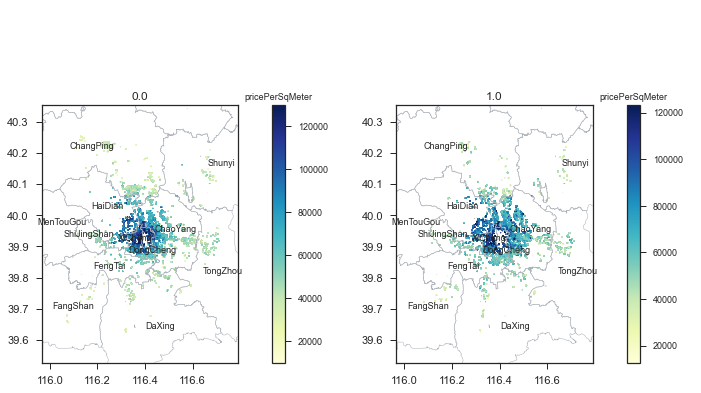

In [33]:
#plot whether hosues have elevator or not on map
numerical_on_map_by_category(data=df, cat='elevator', fighgt=5, figlng=10, ncols=2)

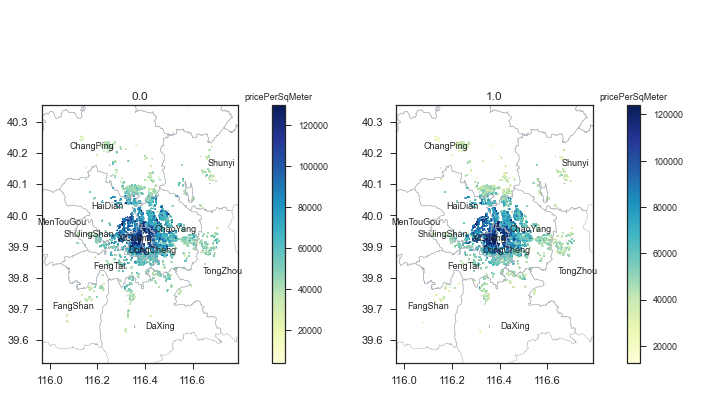

In [34]:
#plot whether houses are fiveYearsProperty or not on map
numerical_on_map_by_category(data=df, cat='fiveYearsProperty', fighgt=5, figlng=10, ncols=2)

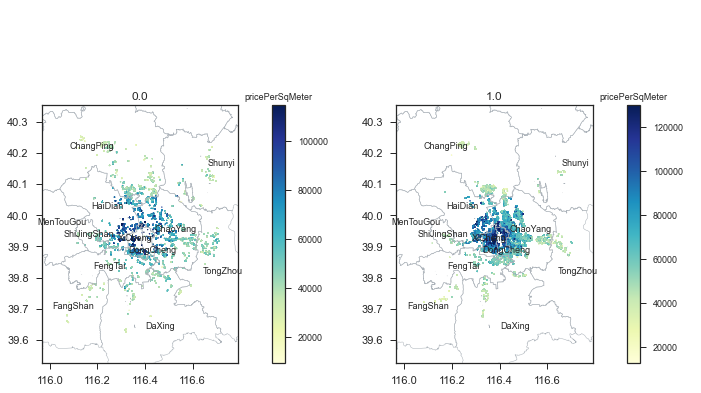

In [35]:
#plot if houses are near subway or not on map
numerical_on_map_by_category(data=df, cat='subway', fighgt=5, figlng=10, ncols=2)

<a id=’Conclusions’></a>
## Conclusions

1. Over **trade time**, house pricing has a increase trend from 2010 to 2016 in all districts. Starting 2017, there was a decrease in pricing

1. House pricing varies in different Beijing **districts** 
    - Xicheng, Dongcheng, Haidian districts which are near the center center have higher price
    - Price in each district has the similar trends over time

2. In terms of **building types**, bungalow houses have higher price then the other types
    - **Bungalow** houses typically locate in the city center in DongCheng and XiCheng districts where the Tiananmen Square and Forbidden city are located, and have only 1 floor with a brick-and-wood structure. Bungalow houses usually have a older construction time than the other types. 
    - There is not much difference in pricing of houses with plate, combination and tower types. 
    - **Tower** buildings are highest building type, mostly over 20 floors. They usually have steel-concrete composite structure
    - **Plate** is the most common house building type in Beijing. Mostly have less than 10 floor with mixed building structure
    - **combination** building type mostly has 10-20 floors with steel-concrete composite building structure

3. In terms of **Renovation condition**, houses with "rough" renovation conditions have a lower price than the "basic" and "upgraded" condition which is expected. There is not much difference in pricing for "basic" and "upgraded" renovation conditions.  

4. **Construction Time** seems to have a negative correlation with the pricing: recently built houses tend to have lower price
    - House have been expanding outward from the city center over time
    - Since 2000, more Tower and Communication types which have more floors have been constructed as the houses expending outward from the city center
    
5. Number of **bedrooms, living rooms, kitchens, bathrooms** have a positive correlation with the total price of the houses, which is expected as houses with more rooms would be larger with more sq. meters.

6. Houses with access to **subways** have have higher price than houses without access to subways
    - Houses with access subways are centered in the urban area where houses do not have access to subways are 